<a href="https://colab.research.google.com/github/RonakMehta21/Advanced-Deep-Learning/blob/master/Assignment2/Linear_Classifier_with_Low_level_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Classifier with Low-level TensorFlow

**TensorFlow** is a Numpy-like library that is GPU or TPU accelerated, with automatic differentiation. This colab doesn't use any high level keras components to build a linear classifier. The linear classifier is used to classify negative and positive numbers. 

The colab leverages [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to record operations for automatic differentiation. To automatically retrieve the gradient of any differentiable expression, `GradientTape` is used and the tensor is watched by invoking the `watch` method. Please refer [TensorFlow basics colab](https://colab.research.google.com/drive/102EGGB2k8NZ4uCVrisDSpYlTQj3iN73s?usp=sharing) for more information.

### Import necessary packages

In [22]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

2.3.0


### Prepare a dataset

In [4]:
num_samples = 10000 # size of the positive and negative numbers

## random samples from multivariate normal distribution is generated using np.random.multivariate_normal method
# The coordinate of the mean is (0,3) in N-dimensional space for negative samples and (3,0) for positive samples
# Cov indicates the covariance matrix of the distribution
negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
print(negative_samples)
print(positive_samples)

[[-0.58357772  5.48505279]
 [-0.02673586  1.85308311]
 [ 0.20518281  2.4606794 ]
 ...
 [-0.19387831  2.67100079]
 [ 1.55273864  4.89710652]
 [ 1.13674341  3.50347779]]
[[ 3.63258115  0.048973  ]
 [ 3.41804249 -0.58364278]
 [ 1.54831139  0.50635053]
 ...
 [ 4.18151625  0.34036878]
 [ 3.23808505 -0.00877393]
 [ 3.45737698  0.43266757]]


In [8]:
# np.vstack is used to stack arrays in sequence vertically (row wise). The function stores the negative and positive samples into a stack array 
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [6]:
# This creates 10000 zeros followed by 10000 ones
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),np.ones((num_samples, 1), dtype='float32')))
print(labels)

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


### Plot the negative and positive samples

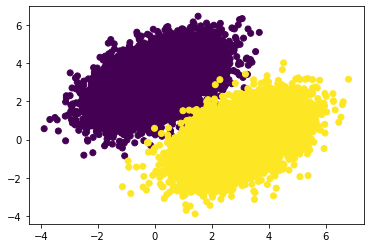

In [9]:
plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

### Shuffle the data

In [10]:
## Randomly permute a sequence
indices = np.random.permutation(len(features))
print(indices)
features = features[indices]
labels = labels[indices]

[ 1469 13376 13503 ... 16609 19889 14747]


In [11]:
# The features and labels are hence randomly shuffled
print(features)
print(labels)

[[ 1.8168961   4.008665  ]
 [ 2.8133163   1.2132363 ]
 [ 3.4815416  -0.8699839 ]
 ...
 [ 4.096129    0.75472605]
 [ 1.5503962  -2.4926107 ]
 [ 1.1372683  -1.359657  ]]
[[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


### Build a Linear Classifier

In [14]:
input_dim = 2 
output_dim = 1
learning_rate = 0.01 # Learning rate

# This is our weight matrix. This matrix contain random values from a uniform distribution.
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
print(w)
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))
print(b)

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.18445826],
       [0.11803281]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


In [19]:
def compute_predictions(features):
  # Multiplies matrix features by matrix w, producing features * w
  # The result is added with bias b
  return tf.matmul(features, w) + b

def compute_loss(labels, predictions):
  # Compute the mean of elements across dimensions of a tensor
  return tf.reduce_mean(tf.square(labels - predictions))

# Compile the training function into a static graph
@tf.function
def train_on_batch(x, y):
  # Compute gradients with GradientTape
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  # adjust network's weights and biases based on gradients of the cost function
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

### Train the linear classifier by iterating batch-by-batch over the data

In [20]:
# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

In [23]:
t0 = time.time()
for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))
t_end = time.time() - t0
print('Time per epoch: %.3f s' % (t_end / 20,))

Epoch 0: last batch loss = 0.0270
Epoch 1: last batch loss = 0.0328
Epoch 2: last batch loss = 0.0171
Epoch 3: last batch loss = 0.0303
Epoch 4: last batch loss = 0.0293
Epoch 5: last batch loss = 0.0277
Epoch 6: last batch loss = 0.0307
Epoch 7: last batch loss = 0.0141
Epoch 8: last batch loss = 0.0258
Epoch 9: last batch loss = 0.0335
Time per epoch: 0.045 s


### Evaluate the model

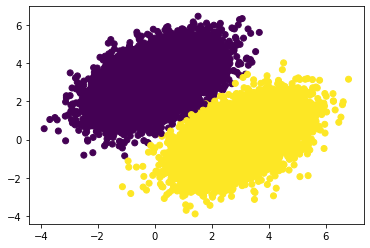

In [24]:
predictions = compute_predictions(features)
plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0] > 0.5)